### Probablistic LSTM Modal

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# data = pd.read_csv("./data_saved/EURUSD_M1_2023.csv")

filename = "EURUSD_M1_2023.csv"


df = pd.read_csv("./data_saved/"+filename)
 # Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp']) 

#timestamp as index
df.set_index('timestamp', inplace=True)
data = df.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

#Drop NA rows
data = data.dropna(axis=0)


# data = data['close']


print(data.head(10))
print(data.describe())

# data = data.iloc[:100]


# # Normalize data
# data_norm = data.copy()
# data_norm[['open', 'high', 'low', 'close']] = (data[['open', 'high', 'low', 'close']] - data[['open', 'high', 'low', 'close']].mean()) / data[['open', 'high', 'low', 'close']].std()


data

            timestamp     open     high      low    close
0 2023-01-01 17:00:00  1.06973  1.07066  1.06899  1.06899
1 2023-01-01 17:15:00  1.06788  1.06788  1.06788  1.06788
2 2023-01-01 17:30:00  1.06904  1.06958  1.06904  1.06934
3 2023-01-01 17:45:00  1.06962  1.07061  1.06823  1.06929
4 2023-01-01 18:00:00  1.06896  1.07040  1.06829  1.06895
5 2023-01-01 18:15:00  1.06933  1.07047  1.06849  1.06939
6 2023-01-01 18:30:00  1.06950  1.06997  1.06923  1.06941
7 2023-01-01 18:45:00  1.06947  1.07012  1.06942  1.06986
8 2023-01-01 19:00:00  1.07007  1.07034  1.06994  1.06999
9 2023-01-01 19:15:00  1.07006  1.07007  1.06948  1.06973
                           timestamp          open          high  \
count                          21632  21632.000000  21632.000000   
mean   2023-07-09 02:56:57.561945344      1.080766      1.081093   
min              2023-01-01 17:00:00      1.045240      1.045590   
25%              2023-04-02 20:56:15      1.068360      1.068660   
50%              2023-

,timestamp,open,high,low,close
0,2023-01-01 17:00:00,1.06973,1.07066,1.06899,1.06899
1,2023-01-01 17:15:00,1.06788,1.06788,1.06788,1.06788
2,2023-01-01 17:30:00,1.06904,1.06958,1.06904,1.06934
3,2023-01-01 17:45:00,1.06962,1.07061,1.06823,1.06929
4,2023-01-01 18:00:00,1.06896,1.07040,1.06829,1.06895
...,...,...,...,...,...
34747,2023-12-29 15:45:00,1.10431,1.10434,1.10383,1.10391
34748,2023-12-29 16:00:00,1.10411,1.10411,1.10341,1.10354
34749,2023-12-29 16:15:00,1.10356,1.10364,1.10339,1.10349
34750,2023-12-29 16:30:00,1.10362,1.10385,1.10358,1.10366


In [4]:
# Convert DataFrame to PyTorch tensor and move to GPU
data_tensor = torch.tensor(data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

# data_tensor = data_tensor[:100]

In [6]:
# # Define the Gaussian LSTM model
# class GaussianLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(GaussianLSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc_mean = nn.Linear(hidden_size, output_size)  # Output mean
#         self.fc_variance = nn.Linear(hidden_size, output_size)  # Output variance

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         mean = self.fc_mean(out[:, -1, :])  # Mean of the Gaussian distribution
#         variance = torch.exp(self.fc_variance(out[:, -1, :]))  # Variance (apply exp to ensure positivity)
#         return mean, variance


In [5]:
class DeterministicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DeterministicLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)  # Output a single point prediction

    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        output = self.fc(lstm_out[-1])  # Use only the last output of the sequence
        return output

In [8]:

# # Train the model
# def train_model(model, criterion, optimizer, data_sequences_tensor, target_labels, num_epochs=100):
#     losses = []
#     for epoch in range(num_epochs):
#         optimizer.zero_grad()
#         mean, variance = model(data_sequences_tensor)
#         loss = criterion(target_labels, mean, variance)
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
#         if (epoch+1) % 10 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#     return losses

# # Define negative log likelihood loss for Gaussian distribution
# def gaussian_nll_loss(y_true, mean, variance):
#     return torch.mean(0.5 * torch.log(variance) + 0.5 * ((y_true - mean) ** 2) / variance)

# # Make predictions and calculate upper and lower bounds
# def predict(model, data_sequences_tensor):
#     mean, variance = model(data_sequences_tensor)
#     std_dev = torch.sqrt(variance)
#     upper_bound = mean + 2 * std_dev  # 95% confidence interval
#     lower_bound = mean - 2 * std_dev  # 95% confidence interval
#     return mean, upper_bound, lower_bound



# # Parameters
# input_size = 1
# hidden_size = 10
# num_layers = 2
# output_size = 1
# sequence_length = 15
# num_epochs = 10
# learning_rate = 0.001

# # Instantiate the model and move to GPU
# model = GaussianLSTM(input_size, hidden_size, num_layers, output_size)

# # Move the model to the same device as the input data
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Loss function and optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Prepare data with sequence length
# data_sequences_tensor = torch.cat([data_tensor[:, i:i+sequence_length, :] for i in range(len(data) - sequence_length)], dim=0)

# # Convert data sequences to PyTorch tensors and move to GPU
# data_sequences_tensor = data_sequences_tensor.to(device)

# # Target labels (using next data point as label for simplicity)
# target_labels = data_tensor[:, sequence_length:, :][:, -1, :].to(device)

# # Train the model
# losses = train_model(model, gaussian_nll_loss, optimizer, data_sequences_tensor, target_labels, num_epochs)

In [28]:
# # Define the window size
# window_size = 10

# # Generate X_train and y_train tensors
# X_train = torch.cat([data_tensor[:, i:i+window_size] for i in range(len(data_tensor[0]) - window_size)], dim=0)
# y_train = data_tensor[:, window_size:].squeeze(0)  # Remove the extra dimension

# # Convert y_train to have an extra dimension for single output
# y_train = y_train.unsqueeze(2)

# # Print shapes for verification
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)

# # Model parameters
# input_size = 1  # Assuming univariate time series
# hidden_size = 32
# learning_rate = 0.001
# num_epochs = 500

# # Create model instance
# model = DeterministicLSTM(input_size, hidden_size)

# # Move the model to the same device as the input data
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Define loss function and optimizer
# criterion = nn.MSELoss()  # Mean Squared Error loss for regression task
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Train the model
# losses = []
# for epoch in range(num_epochs):
#     optimizer.zero_grad()
#     output = model(X_train)
#     loss = criterion(output, y_train)
#     loss.backward()
#     optimizer.step()
#     losses.append(loss.item())
#     if (epoch+1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


X_train shape: torch.Size([21622, 10, 1])
y_train shape: torch.Size([21622, 1, 1])


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([21622, 1, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/500], Loss: 0.6443
Epoch [20/500], Loss: 0.4427
Epoch [30/500], Loss: 0.1839
Epoch [40/500], Loss: 0.0144
Epoch [50/500], Loss: 0.0021
Epoch [60/500], Loss: 0.0061
Epoch [70/500], Loss: 0.0003
Epoch [80/500], Loss: 0.0010
Epoch [90/500], Loss: 0.0004
Epoch [100/500], Loss: 0.0003
Epoch [110/500], Loss: 0.0003
Epoch [120/500], Loss: 0.0003
Epoch [130/500], Loss: 0.0003
Epoch [140/500], Loss: 0.0003
Epoch [150/500], Loss: 0.0003
Epoch [160/500], Loss: 0.0003
Epoch [170/500], Loss: 0.0003
Epoch [180/500], Loss: 0.0003
Epoch [190/500], Loss: 0.0003
Epoch [200/500], Loss: 0.0003
Epoch [210/500], Loss: 0.0003
Epoch [220/500], Loss: 0.0003
Epoch [230/500], Loss: 0.0003
Epoch [240/500], Loss: 0.0003
Epoch [250/500], Loss: 0.0003
Epoch [260/500], Loss: 0.0003
Epoch [270/500], Loss: 0.0003
Epoch [280/500], Loss: 0.0003
Epoch [290/500], Loss: 0.0003
Epoch [300/500], Loss: 0.0003
Epoch [310/500], Loss: 0.0003
Epoch [320/500], Loss: 0.0003
Epoch [330/500], Loss: 0.0003
Epoch [340/500], Lo

In [29]:
# filename = "EURUSD_M1_202401.csv"


# pred_df = pd.read_csv("./data_saved/"+filename)
#  # Convert 'timestamp' column to datetime
# pred_df['timestamp'] = pd.to_datetime(pred_df['timestamp']) 

# #timestamp as index
# pred_df.set_index('timestamp', inplace=True)
# pred_data = df.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

# #Drop NA rows
# pred_data = pred_data.dropna(axis=0)

# # Convert DataFrame to PyTorch tensor and move to GPU
# pred_data_tensor = torch.tensor(pred_data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

# # with torch.no_grad():
# # predicted_output = model(pred_data_tensor)

# # Make predictions
# with torch.no_grad():
#     model.eval()  # Set the model to evaluation mode
#     predicted_output = model(pred_data_tensor)

# print(predicted_output)

# test_loss = criterion(predicted_output, pred_data_tensor)

# print('Test Loss:', test_loss.item())


tensor([[0.3388],
        [0.3387],
        [0.3388],
        ...,
        [0.3399],
        [0.3399],
        [0.3399]], device='cuda:0')
Test Loss: 0.5501474142074585


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 21632, 1])) that is different to the input size (torch.Size([21632, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


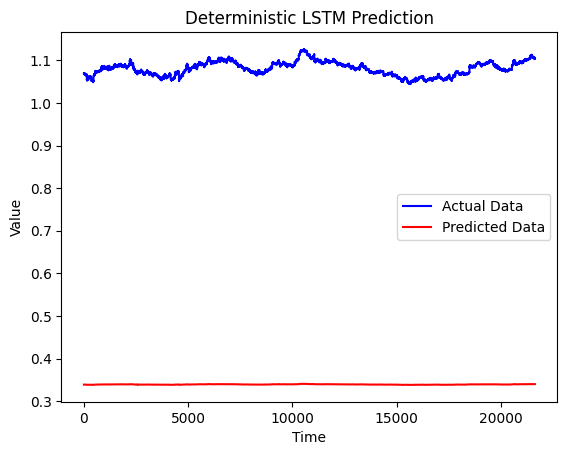

In [30]:
# # Plotting (optional)
# plt.plot(pred_data_tensor[0].cpu().numpy(), label='Actual Data', color='blue')  # Convert tensor to numpy array

# # Generate the range based on the length of the predicted data
# predicted_range = range(0, len(predicted_output))
# plt.plot(predicted_range, predicted_output.cpu().detach().numpy(), label='Predicted Data', color='red')

# plt.title('Deterministic LSTM Prediction')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

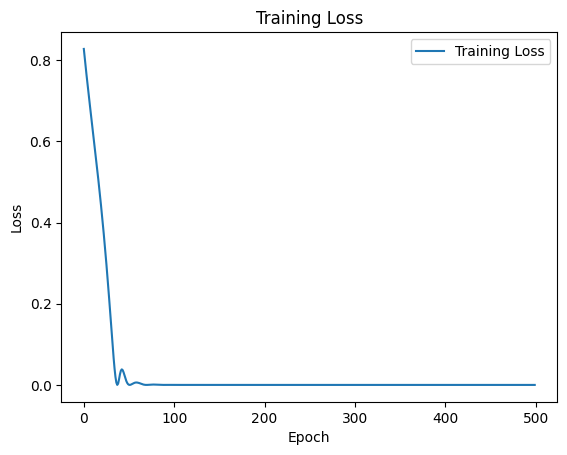

In [31]:
# # Plot loss function within epochs
# plt.plot(losses, label='Training Loss')
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

### Batch training 



In [38]:
# Define the window size

# Assuming you have defined data_tensor, window_size, and target_tensor previously

# Define window size
window_size = 20

# Generate X_train and y_train tensors
X_train = torch.cat([data_tensor[:, i:i+window_size] for i in range(len(data_tensor[0]) - window_size)], dim=0)
y_train = data_tensor[:, window_size:].squeeze(0)  # Remove the extra dimension

# Convert y_train to have an extra dimension for single output
y_train = y_train.unsqueeze(2)

# Split data into training and validation sets
split_ratio = 0.8  # 80% for training, 20% for validation
split_index = int(len(X_train) * split_ratio)

X_train_data, X_val_data = X_train[:split_index], X_train[split_index:]
y_train_data, y_val_data = y_train[:split_index], y_train[split_index:]

# Define batch size
batch_size = 32  # You can adjust this value based on your memory constraints

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_data, y_train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation data
val_dataset = TensorDataset(X_val_data, y_val_data)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Model parameters
input_size = 1  # Assuming univariate time series
hidden_size = 32
learning_rate = 0.0001
num_epochs = 100

# Create model instance
model = DeterministicLSTM(input_size, hidden_size)

# Move the model to the same device as the input data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression task
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Training loop
    model.train()
    for batch_data, batch_target in train_loader:
        batch_data = batch_data.to(device)
        # Reshape batch_target to match the output size
        batch_target = batch_target[:, -1].unsqueeze(1).to(device)
        # batch_target = batch_target.to(device)

        optimizer.zero_grad()
        output = model(batch_data)
        loss = criterion(output, batch_target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_data, batch_target in val_loader:
            batch_data = batch_data.to(device)
            
            batch_target = batch_target[:, -1].unsqueeze(1).to(device)
            # batch_target = batch_target.to(device)

            output = model(batch_data)
            val_loss += criterion(output, batch_target).item()
        val_losses.append(val_loss / len(val_loader))
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([9, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely 

Epoch [10/100], Train Loss: 0.0763, Val Loss: 0.0044
Epoch [20/100], Train Loss: 0.0143, Val Loss: 0.0034


In [34]:
filename = "EURUSD_M1_202401.csv"


pred_df = pd.read_csv("./data_saved/"+filename)
 # Convert 'timestamp' column to datetime
pred_df['timestamp'] = pd.to_datetime(pred_df['timestamp']) 

#timestamp as index
pred_df.set_index('timestamp', inplace=True)
pred_data = df.resample('15min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'}).reset_index()

#Drop NA rows
pred_data = pred_data.dropna(axis=0)

# Convert DataFrame to PyTorch tensor and move to GPU
pred_data_tensor = torch.tensor(pred_data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

# with torch.no_grad():
# predicted_output = model(pred_data_tensor)

# Make predictions
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    predicted_output = model(pred_data_tensor)

print(predicted_output)

test_loss = criterion(predicted_output, pred_data_tensor)

print('Test Loss:', test_loss.item())


tensor([[1.1035],
        [1.1036],
        [1.1035],
        ...,
        [1.1000],
        [1.1000],
        [1.1000]], device='cuda:0')
Test Loss: 0.0007886504754424095


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 21632, 1])) that is different to the input size (torch.Size([21632, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


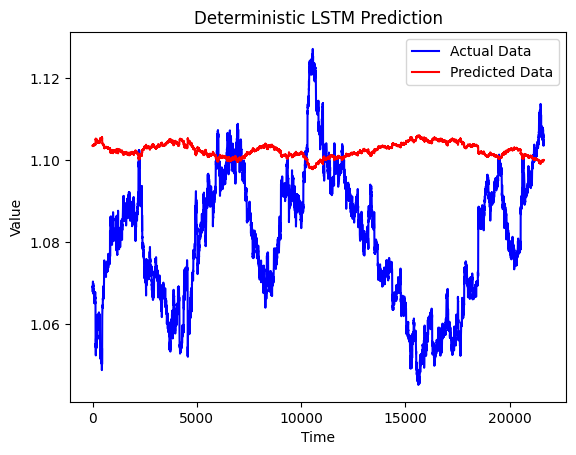

In [35]:
# Plotting (optional)
plt.plot(pred_data_tensor[0].cpu().numpy(), label='Actual Data', color='blue')  # Convert tensor to numpy array

# Generate the range based on the length of the predicted data
predicted_range = range(0, len(predicted_output))
plt.plot(predicted_range, predicted_output.cpu().detach().numpy(), label='Predicted Data', color='red')

plt.title('Deterministic LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [15]:
output.cpu().detach().numpy()

array([[0.9897065 ],
       [0.9897424 ],
       [0.9897374 ],
       [0.9897314 ],
       [0.9897561 ],
       [0.98979044],
       [0.9897717 ],
       [0.989702  ],
       [0.9897277 ],
       [0.98974186],
       [0.9896863 ],
       [0.9896356 ],
       [0.98962396],
       [0.9896022 ],
       [0.98962545],
       [0.9896796 ],
       [0.98966056],
       [0.9896306 ],
       [0.9895967 ],
       [0.98957276]], dtype=float32)

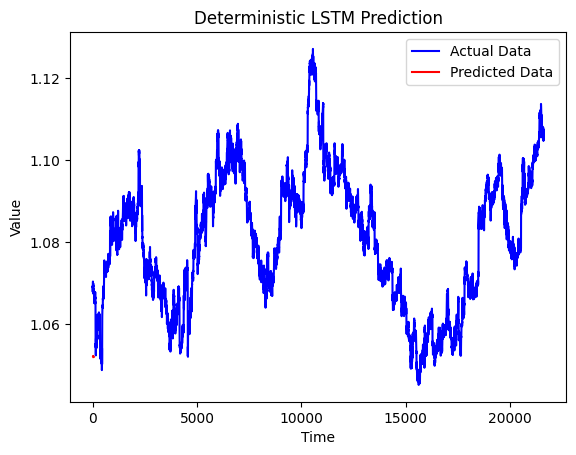

In [36]:
# Plotting (optional)
plt.plot(data_tensor[0].cpu().numpy()[:len(data_tensor[0]) - window_size], label='Actual Data', color='blue')  # Convert tensor to numpy array

# Generate the range based on the length of the predicted data
predicted_range = range(window_size, window_size + len(output))
plt.plot(predicted_range, output.cpu().detach().numpy(), label='Predicted Data', color='red')

plt.title('Deterministic LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [21]:
# Plot loss function within epochs
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Value Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

In [12]:
#### save trained modal
torch.save(model.state_dict(), './TrainedModals/D-LSTM_1M_1000epoch.pth')


In [ ]:
# Make predictions
# mean_pred, upper_bound_pred, lower_bound_pred = predict(model, data_sequences_tensor)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.98 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 10.78 GiB is allocated by PyTorch, and 970.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

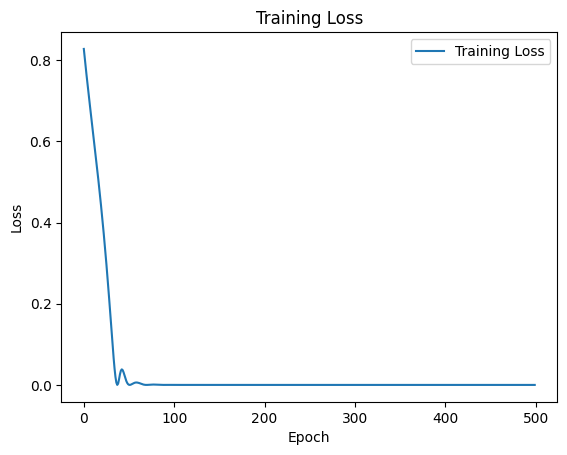

In [37]:
# Plot loss function within epochs
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
data

,timestamp,open,high,low,close
0,2023-01-01 17:05:00,1.06973,1.06978,1.06970,1.06970
1,2023-01-01 17:06:00,1.06966,1.06966,1.06966,1.06966
2,2023-01-01 17:08:00,1.06970,1.06974,1.06970,1.06970
3,2023-01-01 17:10:00,1.06975,1.06980,1.06972,1.06972
4,2023-01-01 17:11:00,1.06972,1.06972,1.06972,1.06972
...,...,...,...,...,...
322632,2023-12-29 16:54:00,1.10388,1.10390,1.10387,1.10387
322633,2023-12-29 16:55:00,1.10389,1.10395,1.10387,1.10387
322634,2023-12-29 16:56:00,1.10394,1.10394,1.10367,1.10367
322635,2023-12-29 16:57:00,1.10366,1.10366,1.10366,1.10366


In [48]:
# upper_bound_pred.squeeze().cpu().detach().numpy()

array([1.10829  , 1.10829  , 1.1082898, ..., 1.1082646, 1.1082647,
       1.1082647], dtype=float32)

In [49]:
# lower_bound_pred

tensor([[1.1014],
        [1.1014],
        [1.1014],
        ...,
        [1.1014],
        [1.1014],
        [1.1014]], device='cuda:0', grad_fn=<SubBackward0>)

In [50]:
# data.close

0         1.06970
1         1.06966
2         1.06970
3         1.06972
4         1.06972
           ...   
322632    1.10387
322633    1.10387
322634    1.10367
322635    1.10366
322636    1.10361
Name: close, Length: 322637, dtype: float64

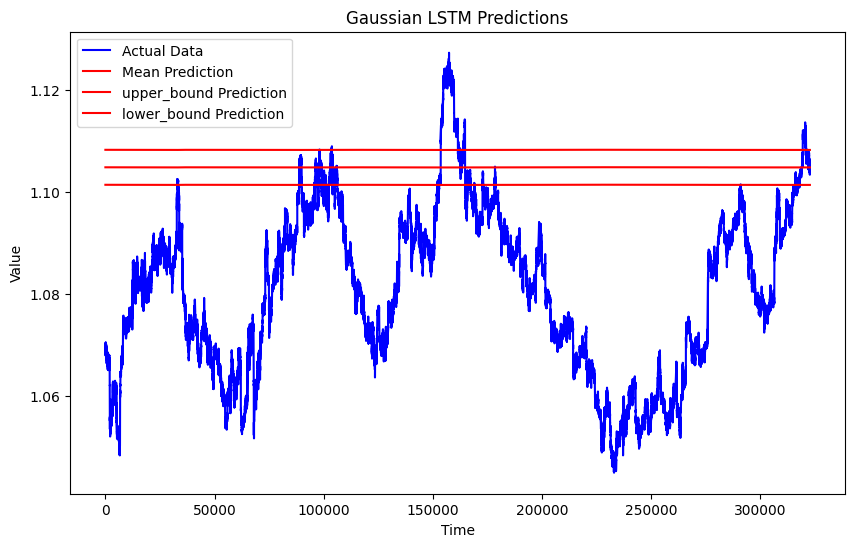

In [51]:
# Plot predictions
def plot_predictions(data, mean, upper_bound, lower_bound):
    # data = data.flatten()
    plt.figure(figsize=(10, 6))
    plt.plot(data['close'], label='Actual Data', color='blue')
    plt.plot(mean, label='Mean Prediction', color='red')
    plt.plot(upper_bound, label='upper_bound Prediction', color='red')
    plt.plot(lower_bound, label='lower_bound Prediction', color='red')
    # plt.fill_between(range(len(mean)), upper_bound, lower_bound, color='orange', alpha=0.3, label='95% Confidence Interval')
    plt.title('Gaussian LSTM Predictions')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Plot predictions
plot_predictions(data, mean_pred.squeeze().cpu().detach().numpy(), 
                  upper_bound_pred.squeeze().cpu().detach().numpy(), 
                  lower_bound_pred.squeeze().cpu().detach().numpy())

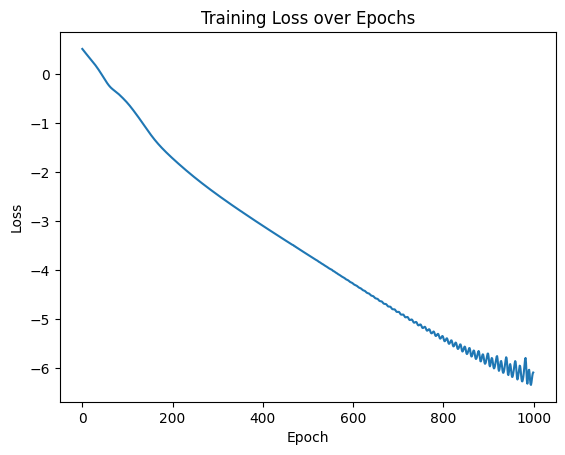

In [52]:
# Visualize the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
# Save PyTorch model
# torch.save(model.state_dict(), './TrainedModals/lstm_probablistic_2023.pth')


In [53]:
# import matplotlib.pyplot as plt

# # Select a subset of 1000 timestamps
# subset_df = predictions_df.iloc[0:100]

# # Plot close price
# plt.figure(figsize=(12, 6))
# plt.plot(subset_df['Timestamp'], data['close'][0:100], label='Close Price', color='black')

# # Add dots to show predictions
# for index, row in subset_df.iterrows():
#     if row['Probability (Up)'] > 0.5:  # Upward movement
#         plt.scatter(row['Timestamp'], data['close'][index], color='green', label='Predicted Up', zorder=1)
#     else:  # Downward movement
#         plt.scatter(row['Timestamp'], data['close'][index], color='red', label='Predicted Down', zorder=1)

# plt.title('Close Price and Predicted Movements')
# plt.xlabel('Timestamp (Hourly)')
# plt.ylabel('Close Price')
# plt.xticks(subset_df['Timestamp'][::100], rotation=45, ha='right')  # Show every 10th timestamp for better readability
# plt.tight_layout()
# plt.show()


NameError: name 'predictions_df' is not defined